In [1]:
! pip install matplotlib

You should consider upgrading via the '/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/bin/python3 -m pip install --upgrade pip' command.


In [22]:
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import config
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import random

query = """select * from assets ORDER BY date ASC;"""
connection = psycopg2.connect(host=config.DB_HOST, database=config.DB_NAME, user= config.DB_USER, password=config.DB_PASS)
cursor = connection.cursor(cursor_factory=psycopg2.extras.DictCursor)
engine = create_engine(f'postgresql://{config.DB_USER}:{config.DB_PASS}@{config.DB_HOST}:{config.DB_PORT}/{config.DB_NAME}')

df = pd.read_sql_query(query,con=engine)
SYMBOLS = ['MSFT','AAPL','NVDA','UBER']
IS_INVESTED = False

In [23]:
df

,name,date,open,high,low,close,adjclose,volume
0,NVDA,2022-04-11 16:30:00,221.000000,222.000000,219.339996,219.755005,219.755005,4567200.0
1,AAPL,2022-04-11 16:30:00,168.500000,168.770004,167.720001,167.770004,167.770004,4688386.0
2,MSFT,2022-04-11 16:30:00,291.750000,292.609985,290.140015,290.970001,290.970001,1741631.0
3,UBER,2022-04-11 16:30:00,31.420000,31.420000,31.110001,31.209999,31.209999,977958.0
4,MSFT,2022-04-11 16:35:00,290.945007,291.570007,289.670013,289.679993,289.679993,877333.0
...,...,...,...,...,...,...,...,...
11851,UBER,2022-06-03 22:50:00,24.105000,24.170000,24.040001,24.170000,24.170000,689255.0
11852,MSFT,2022-06-03 22:55:00,269.970001,270.369995,269.660004,270.049988,270.049988,1217050.0
11853,NVDA,2022-06-03 22:55:00,187.440002,187.839996,187.119995,187.179993,187.179993,1260791.0
11854,UBER,2022-06-03 22:55:00,24.170000,24.200001,24.129999,24.139999,24.139999,977034.0


In [24]:
def get_rsi(df, rsi_period):
    chg = df['close'].diff(1)
    gain = chg.mask(chg<0,0)
    loss = chg.mask(chg>0,0)
    avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
    avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
    rs = abs(avg_gain/avg_loss)
    rsi = 100 - (100/(1+rs))
    return rsi

def add_vwap(df):
    '''Returns dataframe with additional columns:
        vwap (float): Volume Weighted Average Price
        vwap_var (float): % variance of close from vwap
    Args:
        df (pandas.DataFrame): Dataframe with at least columns:
            datetime
            open
            high
            low
            adj_close
            volume
    Returns:
        df (pandas.DataFrame)
    '''
    df['vwap'] = (df['volume']*(df['high']+df['low']+df['adjclose'])/3).cumsum()/df['volume'].cumsum()
    df['vwap'] = df['vwap'].fillna(df['adjclose'])
    df['vwap_var'] = (df['adjclose']/df['vwap'])-1
    return df

In [25]:
def add_indicators(df):
    # relative strength index
    df['rsi14'] = get_rsi(df, 14)
    # moving averages
    df['sma9'] = df['close'].rolling(9).mean()
    df['sma180'] = df['close'].rolling(180).mean()
    df['sma9_var'] = (df['close']/df['sma9'])-1
    df['sma180_var'] = (df['close']/df['sma180'])-1
    # spreads
    df['spread']=((df['close']/df['open'])-1).abs()
    df['spread14_e']=df['spread'].ewm(span=14).mean()
    # volume-based indicator
    df['volume14'] = df['volume'].rolling(14).mean()
    df['volume34'] = df['volume'].rolling(34).mean()
    df['volume14_34_var'] = (df['volume14']/df['volume34'])-1
    df = add_vwap(df)
    return df

In [26]:
df = add_indicators(df)

In [27]:
def drop_na_bf_fill(df):
    """drop_na_bf_fill"""
    df.dropna(axis=0,how='all',inplace=True)
    # df.dropna(axis=1,how='any',inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

In [28]:
def upside_down(df):
    symbols = df['name'].unique()
    df_msft = df[df['name'] == 'MSFT']
    symbol = 'MSFT'
    final_df = pd.DataFrame(data=df_msft[['close','rsi14','sma9','sma180','sma9_var','sma180_var','spread','spread14_e','volume14','volume34','volume14_34_var','vwap','vwap_var']].to_numpy(), index = df_msft['date'],columns=[[f'{symbol}_Close',f'{symbol}_Rsi14',f'{symbol}_Sma9',f'{symbol}_Sma180',f'{symbol}_Sma9_var',f'{symbol}_Sma180_var',f'{symbol}_Spread',f'{symbol}_Spread14_e',f'{symbol}_Volume14',f'{symbol}_Volume34',f'{symbol}_Volume14_34_var',f'{symbol}_Vwap',f'{symbol}_vwap_var']])
    for symbol in symbols:
        if symbol != 'MSFT':
            df_sym = df[df['name'] == symbol]
            df_tmp = pd.DataFrame(data=df_sym[['close','rsi14','sma9','sma180','sma9_var','sma180_var','spread','spread14_e','volume14','volume34','volume14_34_var','vwap','vwap_var']].to_numpy(), index = df_sym['date'],columns=[[f'{symbol}_Close',f'{symbol}_Rsi14',f'{symbol}_Sma9',f'{symbol}_Sma180',f'{symbol}_Sma9_var',f'{symbol}_Sma180_var',f'{symbol}_Spread',f'{symbol}_Spread14_e',f'{symbol}_Volume14',f'{symbol}_Volume34',f'{symbol}_Volume14_34_var',f'{symbol}_Vwap',f'{symbol}_vwap_var']])
            final_df =final_df.join(df_tmp)
    return drop_na_bf_fill(final_df)

In [29]:
df = upside_down(df)


In [30]:
def return_prev(df):
    for symbol in SYMBOLS:
        df[f'{symbol}_Prev_close']=df[f'{symbol}_Close'].shift(1)
        df[f'{symbol}_Return'] = np.array(df[f'{symbol}_Close']) / np.array(df[f'{symbol}_Prev_close']) - 1
        df[f'{symbol}_Log_Return'] = np.log(df[f'{symbol}_Return'] + 1)
    return df

In [31]:
def shifted_log_return(df):
    for symbol in SYMBOLS:
        df[f'{symbol}_Shifted_Log_Return'] = df[f'{symbol}_Log_Return'].shift(-1)
    return df

In [32]:
df = return_prev(df)
df = shifted_log_return(df)

In [33]:
symbol='MSFT'

In [34]:
train_columns = [list(c)[0] for c in df.columns.values if 'MSFT' in str(c)]

In [35]:
train_columns.append('UBER_Shifted_Log_Return')
train_columns.append('AAPL_Shifted_Log_Return')

In [36]:
train_columns.remove('MSFT_Rsi14')
train_columns.remove('MSFT_Sma9')
train_columns.remove('MSFT_Sma180')
train_columns.remove('MSFT_Vwap')
train_columns.remove('MSFT_Spread')
train_columns.remove('MSFT_Close')
# train_columns.remove('MSFT_Log_Return')
# # train_columns.remove('MSFT_Return')
# train_columns.remove('MSFT_Shifted_Log_Return')

In [37]:
df[train_columns]

,MSFT_Sma9_var,MSFT_Sma180_var,MSFT_Spread14_e,MSFT_Volume14,MSFT_Volume34,MSFT_Volume14_34_var,MSFT_vwap_var,MSFT_Prev_close,MSFT_Return,MSFT_Log_Return,MSFT_Shifted_Log_Return,UBER_Shifted_Log_Return,AAPL_Shifted_Log_Return
date,,,,,,,,,,,,,
2022-04-11 16:30:00,0.657653,0.629458,0.004072,1.740913e+06,1.247965e+06,-0.266976,0.390193,NaN,NaN,NaN,-0.004443,0.006069,-0.002776
2022-04-11 16:35:00,0.657653,0.629458,0.004735,1.740913e+06,1.247965e+06,-0.266976,0.439167,290.970001,-0.004433,-0.004443,-0.000034,0.020333,0.002716
2022-04-11 16:40:00,0.657653,0.629458,0.006420,1.740913e+06,1.247965e+06,-0.266976,0.470867,289.679993,-0.000034,-0.000034,-0.000242,0.003271,0.000060
2022-04-11 16:45:00,0.589536,0.629458,0.004399,1.740913e+06,1.247965e+06,-0.266976,0.447417,289.670013,-0.000242,-0.000242,-0.000311,0.005274,-0.002865
2022-04-11 16:50:00,0.523087,0.629458,0.003543,1.110924e+06,1.247965e+06,-0.266976,0.483501,289.600006,-0.000311,-0.000311,-0.006202,0.000000,-0.001736
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-03 22:35:00,0.438821,0.718410,0.001038,5.277834e+05,4.834163e+05,0.091778,0.701522,269.570007,-0.000111,-0.000111,-0.000668,0.000208,-0.001194
2022-06-03 22:40:00,0.592522,0.712277,0.000888,5.141552e+05,4.848351e+05,0.060474,0.700387,269.540009,-0.000668,-0.000668,0.001725,0.001245,0.001228
2022-06-03 22:45:00,0.733714,0.722643,0.001160,5.551208e+05,5.077451e+05,0.093306,0.703386,269.359985,0.001726,0.001725,0.000426,0.002485,0.000516


In [75]:
# train_colums = []

# train_colums.extend([f'{symbol}_Sma9_var',f'{symbol}_Sma180_var',f'{symbol}_Spread14_e'])


df_v = df[train_columns]
df_l =df[f'{symbol}_Shifted_Log_Return']

Ntest = 1600
train_msft = df_v.iloc[1:Ntest]
test_msft = df_v.iloc[Ntest:-1]
train_msft_l = df_l.iloc[1:Ntest]
test_msft_l = df_l.iloc[Ntest:-1]
Ctrain = (train_msft_l>0)
Ctest = (test_msft_l>0)
model = RandomForestClassifier(random_state=10)
model.fit(train_msft, Ctrain)
print(f'Train_Score = {model.score(train_msft, Ctrain)}, Test_Score = {model.score(test_msft,Ctest)}')

Ptrain =model.predict(train_msft)
Ptest =model.predict(test_msft)


Train_Score = 1.0, Test_Score = 0.7903989181879648


save model


In [ ]:
LogisticRegression
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

In [80]:
model.feature_importances_


array([0.02638978, 0.03660691, 0.03126946, 0.03168199, 0.03476252,
       0.03550491, 0.03421602, 0.03408418, 0.0379031 , 0.03811946,
       0.03464365, 0.03258888, 0.03059032, 0.02797901, 0.03139582,
       0.03340089, 0.10818794, 0.36067517])

In [60]:
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities.model_registry.model_version_status import ModelVersionStatus

In [61]:
preprocessor = Pipeline(steps=[('scaler', StandardScaler())])
p_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('randomforestclassifier', model)])

In [62]:
accuracy_train = model.score(train_msft, Ctrain)
accuracy_test = model.score(test_msft, Ctest)

In [63]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

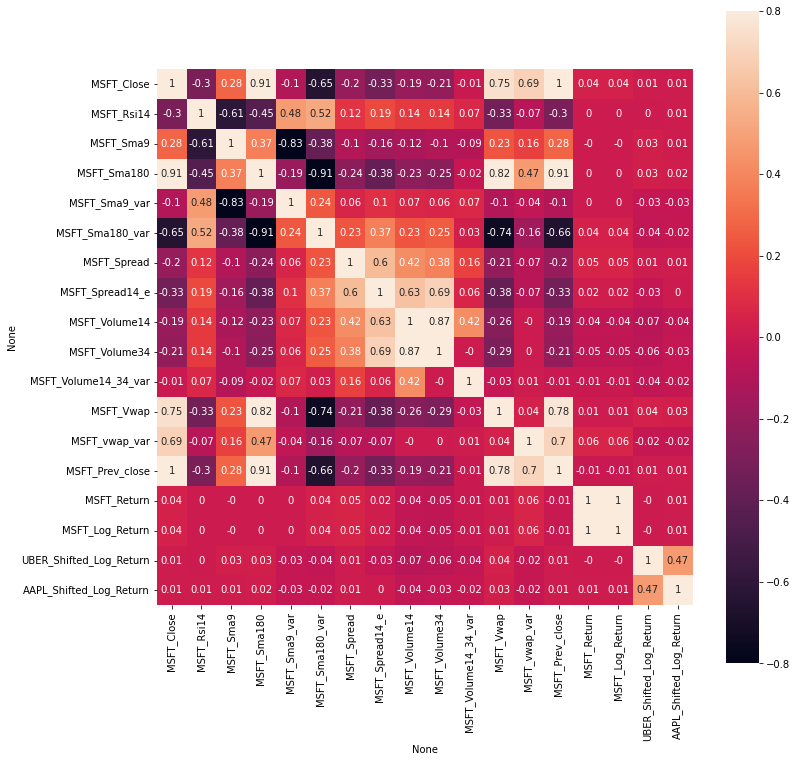

In [ ]:
df_corr = df_v.corr().round(2)
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(df_corr, vmin=-.8, vmax=.8, square=1, annot=True)

In [ ]:
df_l['MSFT_Shifted_Log_Return'] = True

SyntaxError: cannot assign to comparison (414965262.py, line 1)

In [ ]:
fig = plt.figure(figsize = (20, 25))
for i, col in enumerate(df_v.columns):
    print(i, end=' ')
    plt.subplot(((df_v.shape[1]-1)//4)+1, 4, i+1)
    sns.boxplot(x='MSFT_Shifted_Log_Return', y=col, data=df_l)
plt.show()

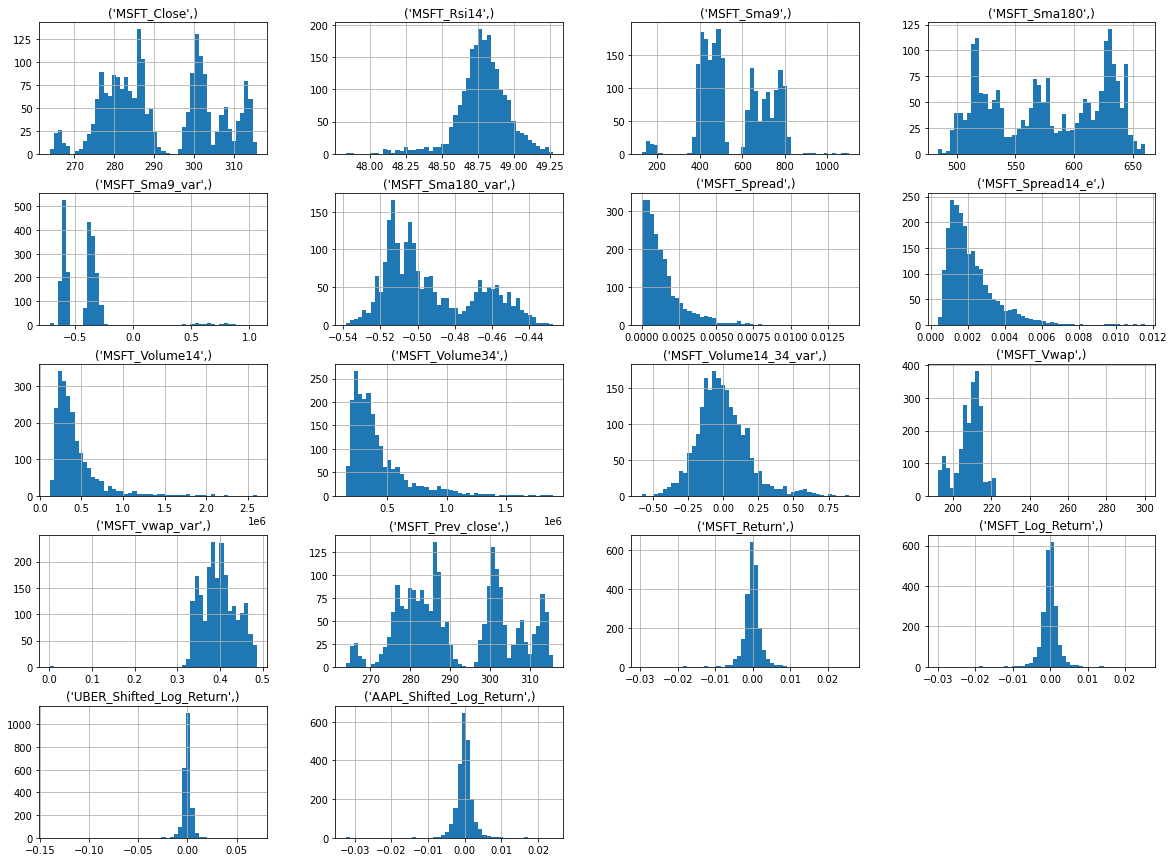

In [ ]:
df_e = df_v.copy()
df_e.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
Ctrain.value_counts()

(MSFT_Shifted_Log_Return,)
False                         827
True                          772
dtype: int64

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [72]:
random_grid = {
    'n_estimators': [800], # Number of trees in random forest
    'max_depth': [2048, None],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 8],
}

model_random_cv = RandomizedSearchCV(
    estimator = model,
    param_distributions = random_grid,
    n_iter = 10,
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
    verbose=2,
    random_state=42,
    n_jobs = -1,
    scoring = 'roc_auc',
    refit=False,
)
model_random_cv.fit(train_msft, Ctrain)
# print(f'Train_Score = {model.score(train_msft, Ctrain)}, Test_Score = {model.score(test_msft,Ctest)}')

# Ptrain =model.predict(train_msft)
# Ptest =model.predict(test_msft)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_par

[CV] END max_depth=2048, max_features=2, min_samples_leaf=2, min_samples_split=4, n_estimators=800; total time=   2.0s
[CV] END max_depth=2048, max_features=2, min_samples_leaf=2, min_samples_split=4, n_estimators=800; total time=   2.0s
[CV] END max_depth=2048, max_features=2, min_samples_leaf=2, min_samples_split=4, n_estimators=800; total time=   2.0s
[CV] END max_depth=2048, max_features=2, min_samples_leaf=2, min_samples_split=4, n_estimators=800; total time=   2.0s
[CV] END max_depth=2048, max_features=2, min_samples_leaf=2, min_samples_split=4, n_estimators=800; total time=   2.1s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_par

[CV] END max_depth=None, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=   2.6s
[CV] END max_depth=None, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=   2.6s
[CV] END max_depth=None, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=   2.7s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_par

[CV] END max_depth=None, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=   2.5s
[CV] END max_depth=None, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=   2.5s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=2048, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.1s
[CV] END max_depth=2048, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.9s
[CV] END max_depth=2048, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.9s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_par

[CV] END max_depth=2048, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   3.0s
[CV] END max_depth=2048, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.8s
[CV] END max_depth=2048, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.8s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=2048, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.0s
[CV] END max_depth=2048, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.0s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=2048, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.0s
[CV] END max_depth=2048, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.0s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=2048, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=800; total time=   3.1s
[CV] END max_depth=2048, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=800; total time=   3.3s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=2048, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=800; total time=   3.1s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=2048, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=800; total time=   3.3s
[CV] END max_depth=None, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=   2.3s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=None, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=   2.2s
[CV] END max_depth=None, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=   2.4s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=2048, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=800; total time=   3.2s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=None, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=   2.3s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=None, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=800; total time=   2.5s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=2048, max_features=3, min_samples_leaf=1, min_samples_split=4, n_estimators=800; total time=   2.6s
[CV] END max_depth=2048, max_features=3, min_samples_leaf=1, min_samples_split=4, n_estimators=800; total time=   2.4s
[CV] END max_depth=2048, max_features=3, min_samples_leaf=1, min_samples_split=4, n_estimators=800; total time=   2.5s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_par

[CV] END max_depth=2048, max_features=3, min_samples_leaf=1, min_samples_split=4, n_estimators=800; total time=   2.5s
[CV] END max_depth=2048, max_features=3, min_samples_leaf=1, min_samples_split=4, n_estimators=800; total time=   2.7s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=2048, max_features=5, min_samples_leaf=4, min_samples_split=4, n_estimators=800; total time=   3.4s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=2048, max_features=5, min_samples_leaf=4, min_samples_split=4, n_estimators=800; total time=   3.3s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=2048, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   2.8s
[CV] END max_depth=2048, max_features=5, min_samples_leaf=4, min_samples_split=4, n_estimators=800; total time=   3.4s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=2048, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   2.7s
[CV] END max_depth=2048, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   2.7s
[CV] END max_depth=2048, max_features=5, min_samples_leaf=4, min_samples_split=4, n_estimators=800; total time=   3.4s
[CV] END max_depth=2048, max_features=5, min_samples_leaf=4, min_samples_split=4, n_estimators=800; total time=   3.4s


/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/utkusaglam/Desktop/projects/senioryrproject/src/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_par

[CV] END max_depth=2048, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   2.7s
[CV] END max_depth=2048, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   2.2s
[CV] END max_depth=None, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.5s
[CV] END max_depth=None, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.5s
[CV] END max_depth=None, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.3s
[CV] END max_depth=None, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.3s
[CV] END max_depth=None, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.3s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=10), n_jobs=-1,
                   param_distributions={'max_depth': [2048, None],
                                        'max_features': [2, 3, 4, 5],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': [800]},
                   random_state=42, refit=False, scoring='roc_auc', verbose=2)

In [ ]:
import pprint

In [ ]:
# Print results
for tup in sorted(zip(model_random_cv.cv_results_['params'], model_random_cv.cv_results_['mean_test_score']), key = lambda x: x[1], reverse=1):
    pprint.pprint(tup[0])
    print(round(tup[1], 5))
    print()

{'max_depth': 2048,
 'max_features': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 800}
0.85951

{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 800}
0.85905

{'max_depth': 2048,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 800}
0.85747

{'max_depth': 2048,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}
0.85699

{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}
0.85699

{'max_depth': 2048,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 800}
0.85608

{'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 800}
0.85529

{'max_depth': 2048,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 800}
0.85516

{'max_depth': 2048,
 'max_features': 2,


NameError: name 'model' is not defined

roc_auc_score: 0.8361577931553924
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00343643 0.00343643 0.00687285
 0.01030928 0.01030928 0.0137457  0.01718213 0.02061856 0.02749141
 0.03092784 0.03780069 0.04810997 0.05841924 0.07560137 0.0790378
 0.08934708 0.08934708 0.10309278 0.10996564 0.11340206 0.11683849
 0.12027491 0.12714777 0.13058419 0.14089347 0.14776632 0.15463918
 0.17525773 0.17869416 0.18556701 0.18900344 0.20962199 0.22680412
 0.24742268 0.25429553 0.26804124 0.28865979 0.29553265 0.3024055
 0.31958763 0.33333333 0.34707904 0.36426117 0.38831615 0.39862543
 0.41237113 0.42611684 0.45360825 0.46735395 0.51546392 0.54295533
 0.56013746 0.56701031 0.60137457 0.6185567  0.62886598 0.66323024
 0.68728522 0.71134021 0.73539519 0.79037801 0.81786942 0.83505155
 0.84536082 0.87628866 0.90034364 0.91752577 0.93814433 0.95189003
 0.96219931 0.97938144 0.98281787 0.99656357 1.        ]
[0.         0.00342466 0.01369863 0.03082192 0.0

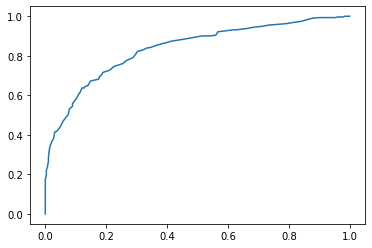

In [ ]:
y_test_pp = model.predict_proba(test_msft)
print('roc_auc_score:', roc_auc_score(Ctest, y_test_pp[:,1]))
fpr, tpr, thres = roc_curve(Ctest, y_test_pp[:,1])
print(fpr)
print(tpr)
print(thres)
ax = plt.plot(fpr, tpr)
plt.show()